<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-time-series-for-2D-variables" data-toc-modified-id="Plot-time-series-for-2D-variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot time series for 2D variables</a></span><ul class="toc-item"><li><span><a href="#Variables-directly-output-by-the-model" data-toc-modified-id="Variables-directly-output-by-the-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Variables directly output by the model</a></span></li><li><span><a href="#Secondary-variables" data-toc-modified-id="Secondary-variables-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Secondary variables</a></span></li></ul></li><li><span><a href="#Plot-timeseries-for-3D-variables" data-toc-modified-id="Plot-timeseries-for-3D-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot timeseries for 3D variables</a></span></li><li><span><a href="#Animation-for-OLR,-IWP,-LWP,-PR,-TS" data-toc-modified-id="Animation-for-OLR,-IWP,-LWP,-PR,-TS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animation for OLR, IWP, LWP, PR, TS</a></span><ul class="toc-item"><li><span><a href="#calculate-albedo" data-toc-modified-id="calculate-albedo-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>calculate albedo</a></span></li><li><span><a href="#joint-histogram" data-toc-modified-id="joint-histogram-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>joint histogram</a></span></li><li><span><a href="#spatial-plots" data-toc-modified-id="spatial-plots-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>spatial plots</a></span></li></ul></li></ul></div>

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
import util
warnings.filterwarnings('ignore')
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"
run="j_296K"

comp_name = "sst"

if comp_name=="small":
    runs = ["f_default","g_halfsed","g_2xsed","g_halfdep", "g_2xdep"]
    run_names = ["Default","1/2x sed","2x sed","1/2x dep", "2x dep"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="all":
    runs = ["f_default","h_halfsed_all","h_2xsed_all","h_halfdep_all", "h_2xdep_all"]
    run_names = ["Default","1/2x sed (all)","2x sed (all)","1/2x dep (all)", "2x dep (all)"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="sed":
    runs = ["f_default","g_halfsed","g_2xsed","h_halfsed_all", "h_2xsed_all"]
    run_names = ["Default","1/2x sed (small)","2x sed (small)","1/2x sed (all)", "2x sed (all)"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="dep":
    runs = ["f_default","g_halfdep","g_2xdep","h_halfdep_all", "h_2xdep_all", "i_lsascent_a"]
    run_names = ["Default","1/2x dep (small)","2x dep (small)","1/2x dep (all)", "2x dep (all)", "LS ascent"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen", "darkviolet"]
elif comp_name=="other":
    runs = ["f_default", "f_def_pbogen_updates","i_bgicenuc", "i_lsascent_a"]
    run_names = ["Default","Def w/ RCE updates","New ice nuc", "LS ascent"]
    colors = ["darkred","salmon","lightcoral", "darkviolet"]
elif comp_name=="sst":
    runs = ["f_default","j_304K","j_296K"]
    run_names = ["Default (300K)","Warm SST (304K)","Cool SST (296K)"]
    colors = ["grey","maroon","lightblue"]

# Plot time series for 2D variables

We plot the time series of each variable in the file. We just plot relevant variables by getting var names from a list saved in this directory ([h1_varnames](h1_varnames)).

## plot 2d timeseries for one run

In [2]:
## Variables directly output by the model
# run="f_def_pertlim_01"
# list of relevant var names modified from 'list(ds.keys())'
varnames = open("h1_varnames","r").read().split("\n")
# varnames = ["FLUT", "FLUTC", "FSNT", "FSNTC", "FSUTOA", "FSUTOAC", "LWCF", "SWCF","SOLIN","TS"]
len(varnames)

45

In [3]:
ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(run, run))

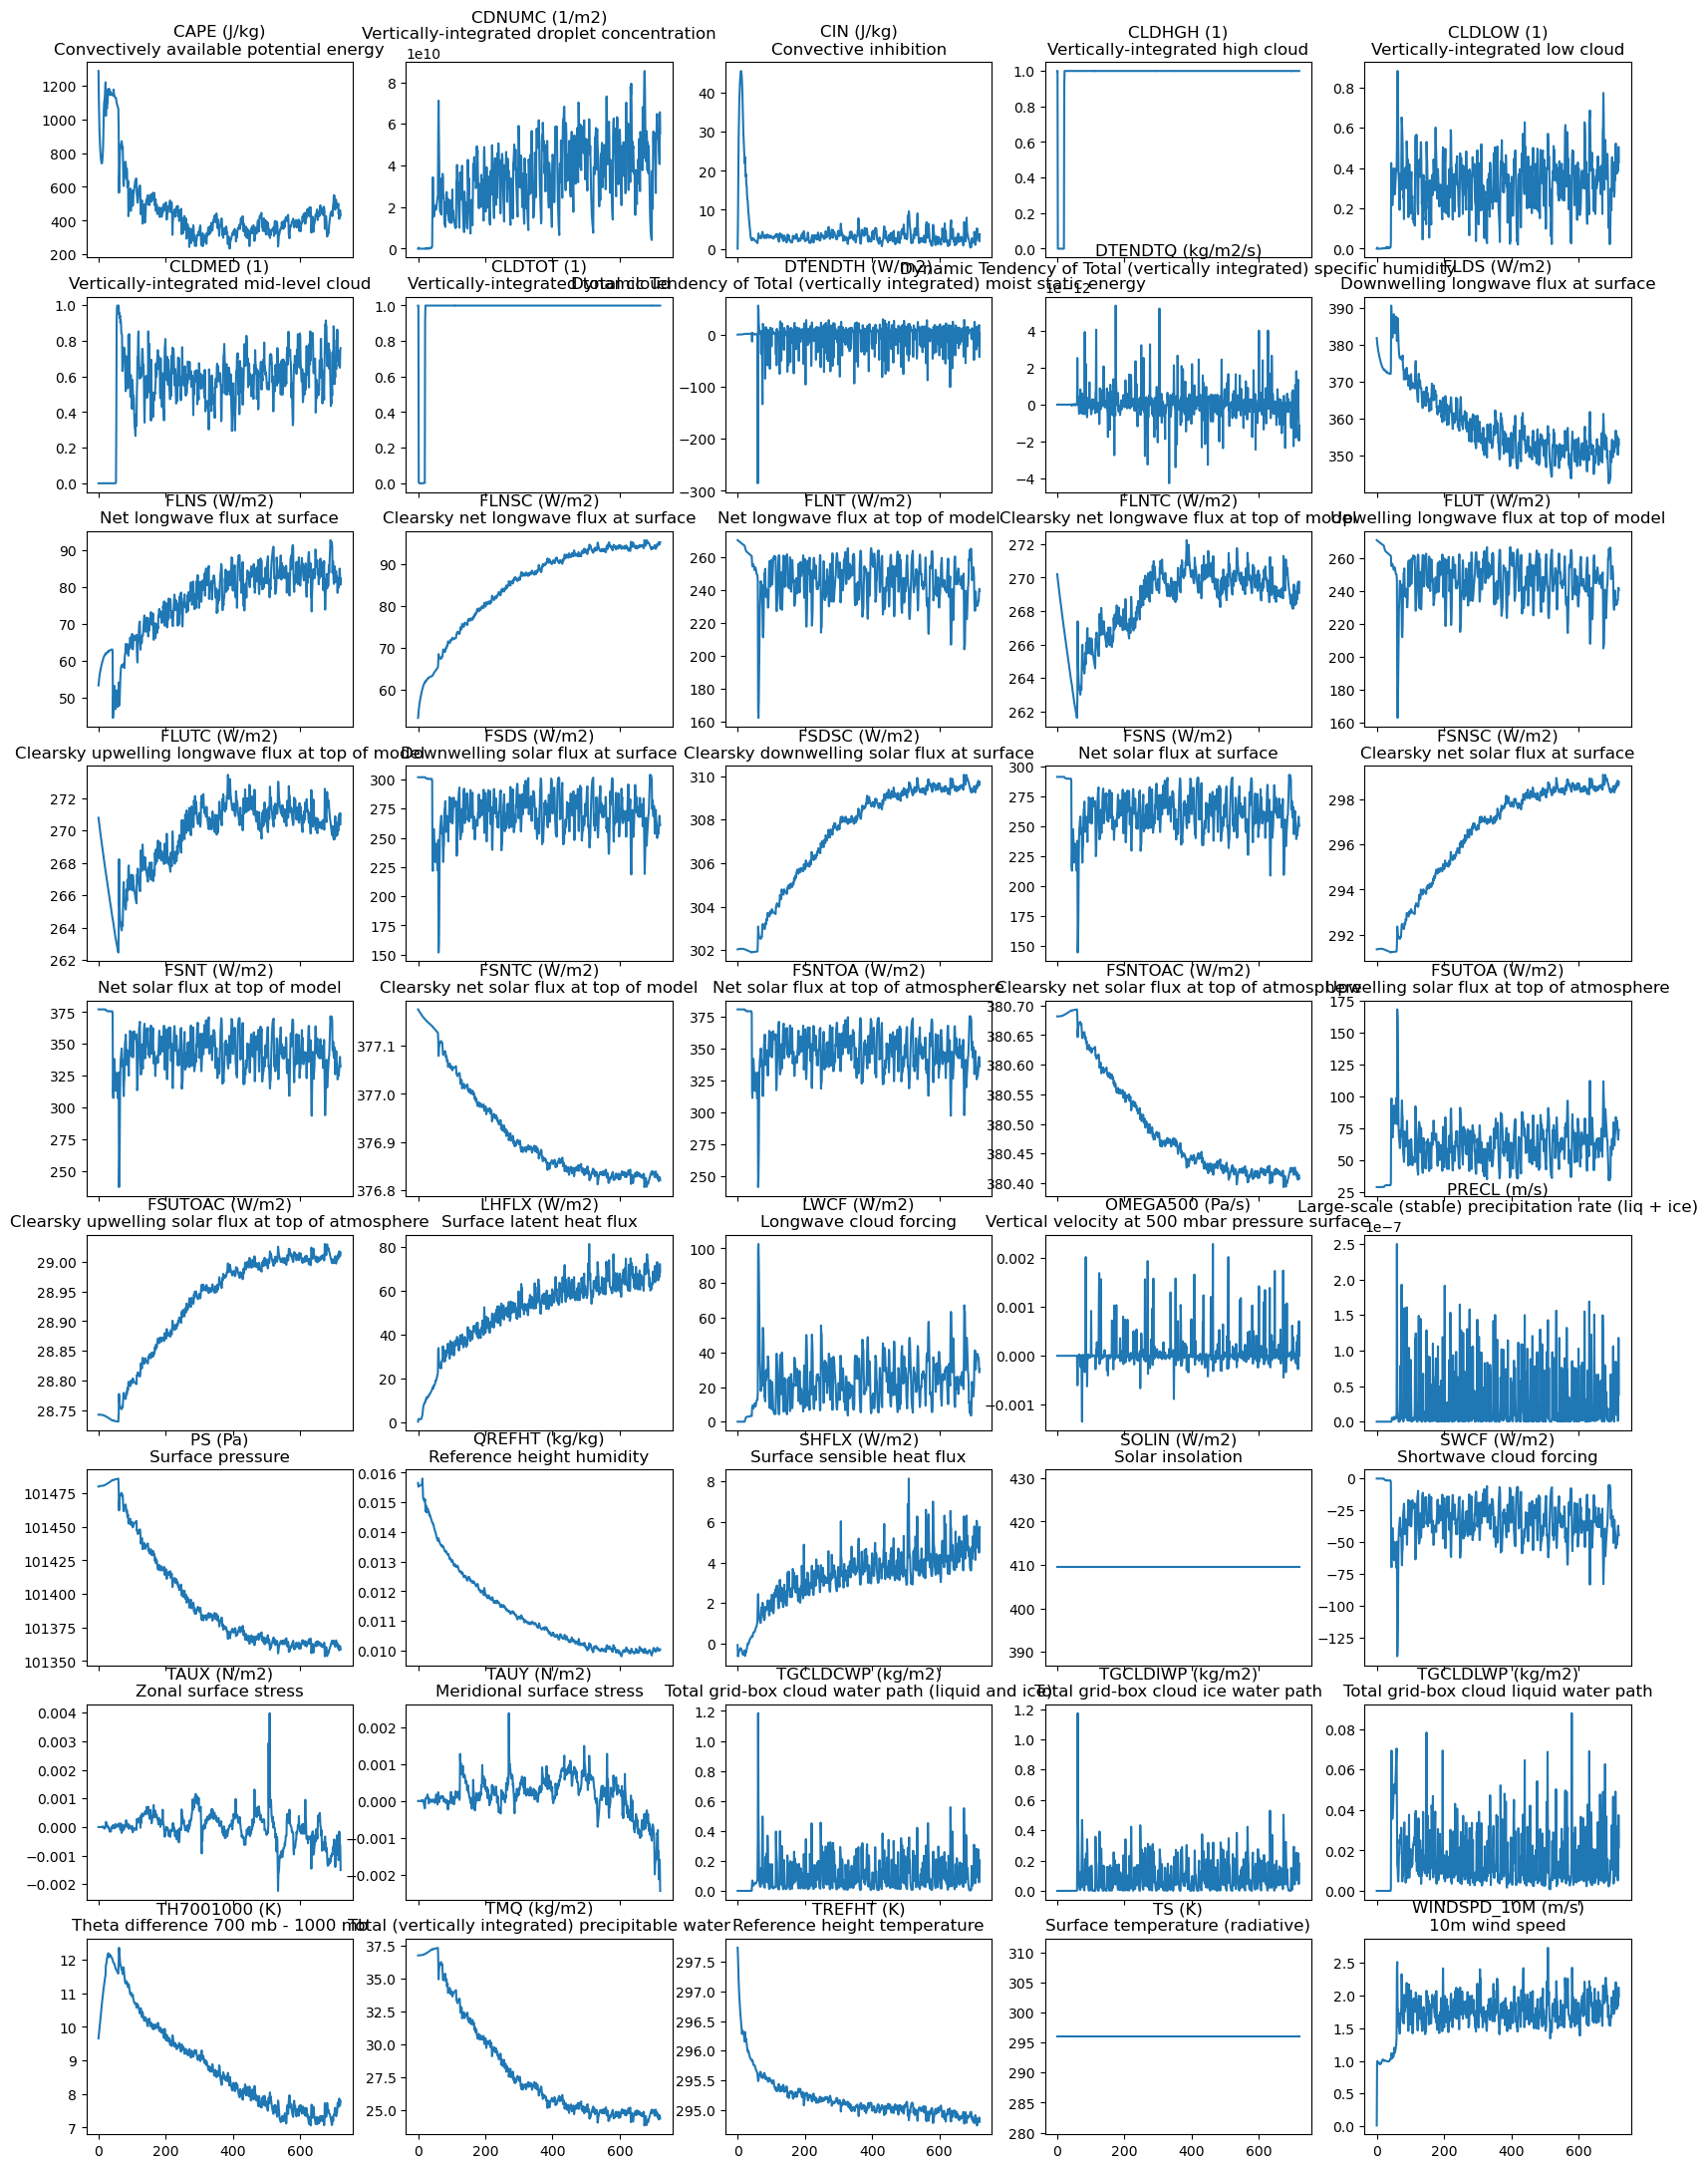

In [4]:
r,c = 9,5 #2,5 
fig, ax = plt.subplots(r,c, figsize=(c*4,r*3), sharex=True)
n = 0
for i in range(r):
    for j in range(c):
        var = varnames[n]
        data_weighted_avg = ds[var].weighted(ds.area).mean(dim=["ncol"])
#         data = ds[var][:,40]
        ax[i,j].plot(data_weighted_avg[:-1])
        ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
        n+=1
plt.savefig("plots/timeseries_h1_mean_run_{}.png".format(run),dpi=140)
plt.show()

## Secondary radiative variables for several runs

- Net downward radiative flux at top of atmosphere: RTOA = FSNTOA-FLUT
- Clearsky version: RTOACLR = FSNTOAC-FLUTC
- Net downward radiative flux at top of the model: RTOM = FSNT-FLNT 
- Net downwards radiative flux at surface: RSFC = FSNS-FLNS
- Clearsky version: RSFCCLR = FSNSC-FLNSC
- Energy input into Ocean = QOCN = RSFC-LHFLX-SHFLX
- Net heating of atmosphere (in W/m2): QATM = RTOM-QOCN
- Precipitation (in W/m2) --- convert from m/s (multiply by latent heat of condensation, Lcond, and density of liquid water, I think)
- Atmospheric cloud radiative effect: ACRE = RTOA-RTOACLR - (RSFC-RSFCCLR) 


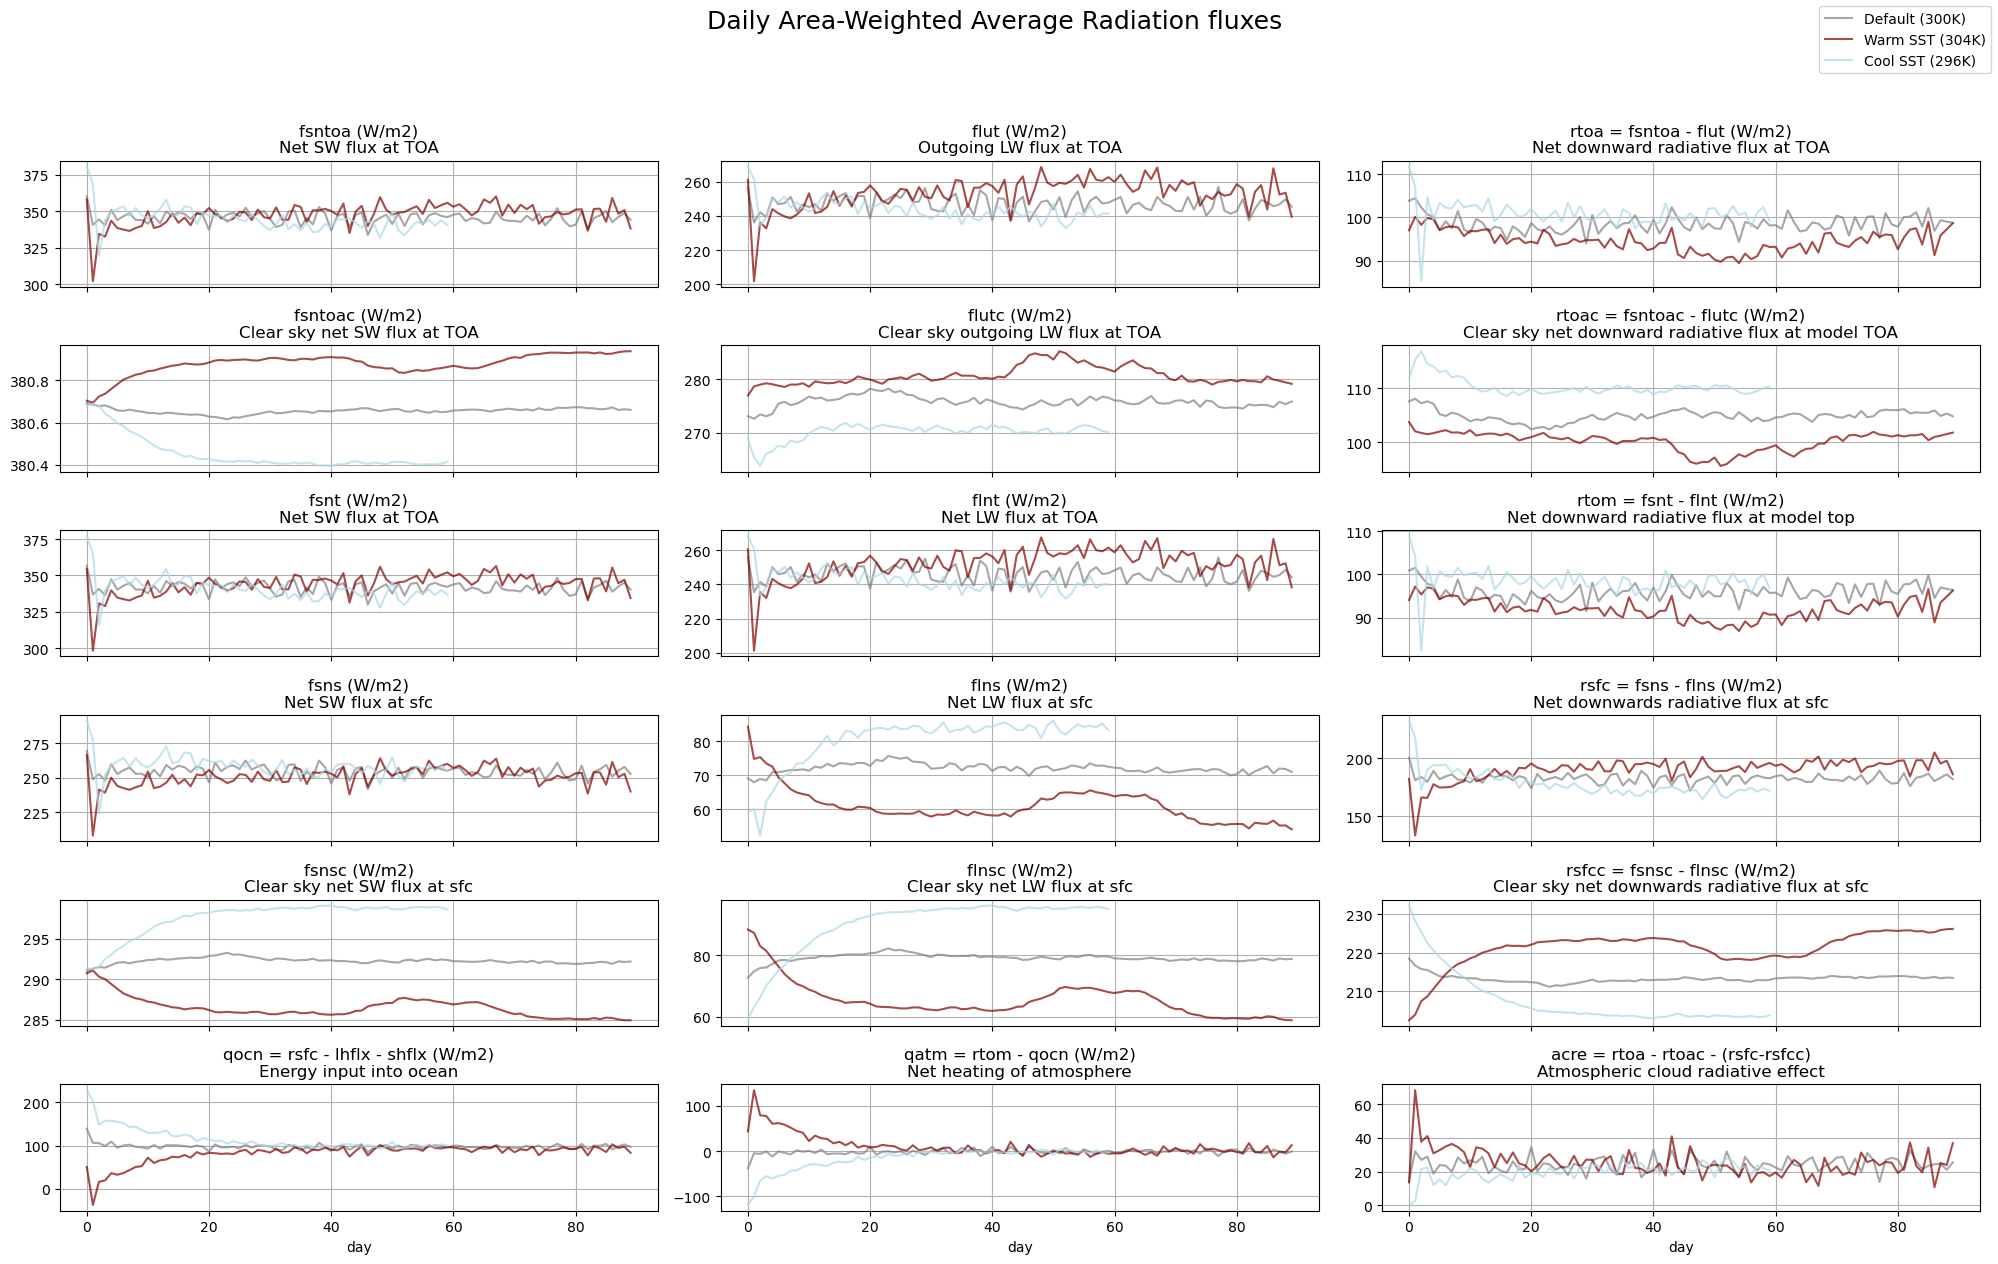

In [2]:
fig, ax = plt.subplots(6,3, figsize=(20,12), sharex=True)

for j in range(len(runs)):
    
    ds = xr.open_dataset(run_dir+\
                         "scream_dp_RCE_SMALL_3km_"+runs[j]+\
                         "/run/scream_dp_RCE_SMALL_3km_"+runs[j]+\
                         ".eam.h1.2000-01-01-00000.nc")
    # secondary variables (radiation related)
    rtoa = ds["FSNTOA"]-ds["FLUT"]
    rtoac = ds["FSNTOAC"]-ds["FLUTC"]
    rtom = ds["FSNT"]-ds["FLNT"]
    rsfc = ds["FSNS"]-ds["FLNS"]
    rsfcc = ds["FSNSC"]-ds["FLNSC"]
    qocn = rsfc-ds["LHFLX"]-ds["SHFLX"]
    qatm = rtom-qocn
    acre = rtoa-rtoac-(rsfc-rsfcc)

    # daily weighted averages (and average over space)
    fsntoa_da = ds["FSNTOA"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    flut_da = ds["FLUT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    rtoa_da = rtoa.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    fsntoac_da = ds["FSNTOAC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    flutc_da = ds["FLUTC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    rtoac_da = rtoac.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    fsnt_da = ds["FSNT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    flnt_da = ds["FLNT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    rtom_da = rtom.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    fsns_da = ds["FSNS"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    flns_da = ds["FLNS"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    rsfc_da = rsfc.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    fsnsc_da = ds["FSNSC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    flnsc_da = ds["FLNSC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    rsfcc_da = rsfcc.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    qocn_da = qocn.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    qatm_da = qatm.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
    acre_da = acre.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

    day = range(len(fsntoa_da.time)-1)
    # plot daily averages

    a=0.7
    i=0 # FSNTOA, FLUT, RTOA
    if j>2:
        ls = 'dashed'
    else:
        ls = 'solid'
    ax[i,0].plot(day, fsntoa_da[:-1], color=colors[j], label=run_names[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, flut_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, rtoa_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("fsntoa (W/m2)\nNet SW flux at TOA")
    ax[i,1].set_title("flut (W/m2)\nOutgoing LW flux at TOA")
    ax[i,2].set_title("rtoa = fsntoa - flut (W/m2)\nNet downward radiative flux at TOA")

    i=1 # FSNTOAC, FLUTC, RTOAC
    ax[i,0].plot(day, fsntoac_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, flutc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, rtoac_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("fsntoac (W/m2)\nClear sky net SW flux at TOA")
    ax[i,1].set_title("flutc (W/m2)\nClear sky outgoing LW flux at TOA")
    ax[i,2].set_title("rtoac = fsntoac - flutc (W/m2)\nClear sky net downward radiative flux at model TOA")

    i=2 # FSNT, FLNT, RTOM
    ax[i,0].plot(day, fsnt_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, flnt_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, rtom_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("fsnt (W/m2)\nNet SW flux at TOA")
    ax[i,1].set_title("flnt (W/m2)\nNet LW flux at TOA")
    ax[i,2].set_title("rtom = fsnt - flnt (W/m2)\nNet downward radiative flux at model top")

    i=3 # FSNS, FLNS, RSFC
    ax[i,0].plot(day, fsns_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, flns_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, rsfc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("fsns (W/m2)\nNet SW flux at sfc")
    ax[i,1].set_title("flns (W/m2)\nNet LW flux at sfc")
    ax[i,2].set_title("rsfc = fsns - flns (W/m2)\nNet downwards radiative flux at sfc")

    i=4 # FSNSC, FLNSC, RSFCC
    ax[i,0].plot(day, fsnsc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, flnsc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, rsfcc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("fsnsc (W/m2)\nClear sky net SW flux at sfc")
    ax[i,1].set_title("flnsc (W/m2)\nClear sky net LW flux at sfc")
    ax[i,2].set_title("rsfcc = fsnsc - flnsc (W/m2)\nClear sky net downwards radiative flux at sfc")

    i=5 # QOCN, QATM, ACRE
    ax[i,0].plot(day, qocn_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,1].plot(day, qatm_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    ax[i,2].plot(day, acre_da[:-1], color=colors[j], alpha=a, linestyle=ls)
    # title
    ax[i,0].set_title("qocn = rsfc - lhflx - shflx (W/m2)\nEnergy input into ocean")
    ax[i,1].set_title("qatm = rtom - qocn (W/m2)\nNet heating of atmosphere")
    ax[i,2].set_title("acre = rtoa - rtoac - (rsfc-rsfcc)\nAtmospheric cloud radiative effect")

for k in range(6):
    for l in range(3):
        ax[k,l].grid(True)
        ax[-1,l].set_xlabel("day")
fig.suptitle("Daily Area-Weighted Average Radiation fluxes", y=1.05, fontsize=18)
fig.legend()
plt.tight_layout()
plt.savefig("plots/timeseries_dailyavg_radiation_{}.png".format(comp_name), dpi=140, pad_inches=0.3)
plt.show()

# Plot timeseries for 3D variables

In [6]:
ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run, run))
ds

<xarray.Dataset>
Dimensions:                   (ncol: 1296, lev: 128, ilev: 129, swband: 14,
                               lwband: 16, P3_input_dim: 16, P3_output_dim: 32,
                               time: 481, nbnd: 2)
Coordinates:
  * lev                       (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
  * ilev                      (ilev) float64 2.255 2.905 3.555 ... 997.0 1e+03
  * swband                    (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * lwband                    (lwband) float64 130.0 375.0 ... 2.965e+03
  * P3_input_dim              (P3_input_dim) int32 1 2 3 4 5 ... 12 13 14 15 16
  * P3_output_dim             (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                      (time) object 2000-01-01 00:00:00 ... 2000-03-0...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/223)
    lat                       (ncol) float64 ...
    lon                       (ncol) float64 ...
    area                      (ncol) float64 ...
    hyam                      (lev) float64 ...
    hybm                      (lev) float64 ...
    P0                        float64 ...
    ...                        ...
    crm_grid_x                (time, ncol) float32 ...
    crm_grid_y                (time, ncol) float32 ...
    hstobie_linoz             (time, lev, ncol) float32 ...
    liq_ice_exchange          (time, lev, ncol) float32 ...
    vap_ice_exchange          (time, lev, ncol) float32 ...
    vap_liq_exchange          (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         382e8c7a0e
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_3

In [7]:
# list of relevant var names modified from 'list(ds.keys())'
file="h0_varnames_3Dlev"
varnames = open(file,"r").read().split("\n")  
len(varnames)

50

In [ ]:
if file=="h0_varnames_2D":
    a,b = 9,7
    fig, ax = plt.subplots(a,b, figsize=(40,45), sharex=True, sharey=True)
    n = 0
    for i in range(a):
        for j in range(b):
            if n<len(varnames):
                var = varnames[n]
                ax[i,j].plot(ds[var].weighted(ds.area).mean(dim=["ncol"]))
                ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
                n+=1
            else:
                ax[i,j].axis("off")
    plt.savefig("plots/timeseries_h0_2D_{}.png".format(run),dpi=140)
    plt.show()
elif file=="h0_varnames_3Dlev":
    a,b = 10,5,
    fig, ax = plt.subplots(a,b, figsize=(40,45), sharex=True, sharey=True)
    n = 0
    for i in range(a):
        for j in range(b):
            if n<len(varnames):
                var = varnames[n]
                pc = ax[i,j].pcolormesh(range(len(ds.time)), ds.lev.values, ds[var].weighted(ds.area).mean(dim=["ncol"]).T)
                ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
                ax[i,j].set_yscale("log")
#                 ax[i,j].yaxis_inverted()
                ax[i,j].set_ylim(bottom=1000, top=90)
                plt.colorbar(pc, ax=ax[i,j])
                n+=1
            else:
                ax[i,j].axis("off")
    plt.savefig("plots/timeseries_h0_3Dlev_{}.png".format(run),dpi=140)
    plt.show()
elif file=="h0_varnames_3Dilev":
    a,b = 5,2
    fig, ax = plt.subplots(a,b, figsize=(15,10), sharex=True)
    n = 0
    for i in range(a):
        for j in range(b):
            if n<len(varnames):
                var = varnames[n]
                pc = ax[i,j].pcolormesh(range(len(ds.time)), ds.ilev.values, ds[var].weighted(ds.area).mean(dim=["ncol"]).T)
                ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
#                 ax[i,j].invert_yaxis()
                plt.colorbar(pc, ax=ax[i,j])
                n+=1
            else:
                ax[i,j].axis("off")
    
    plt.savefig("plots/timeseries_h0_3Dilev_{}.png".format(run),dpi=140)
    plt.show()
else:
    raise Exception("check file name: {}".format(file))


In [ ]:
# plot ice and liquid properties
# AREI, CLDICE, AWNI, CLOUDFRAC_ICE_MICRO, NUMICE, IWC
# AREL, CLDLIQ, AWNC, CLOUDFRAC_LIQ_MICRO, NUMLIQ, --
# ICE_CLOUD_FRAC, LIQ_CLOUD_FRAC, PRECIPITATING_ICE_FRAC, CLOUDFRAC_RAIN_MICRO, TOT_CLOUD_FRAC, --
# CLOUD, CLDRIM, QRL, QRS, NUMRAI, RELHUM
ndays = 20

fig, ax = plt.subplots(4,6, figsize=(40,20), sharex=True, sharey=True)
days = range(len(ds.time[-ndays:]))

var = np.array(
    [["AREI", "CLDICE", "AWNI", "CLOUDFRAC_ICE_MICRO", "NUMICE", "IWC"],
       ["AREL", "CLDLIQ", "AWNC", "CLOUDFRAC_LIQ_MICRO", "NUMLIQ", None],
       ["ICE_CLOUD_FRAC", "LIQ_CLOUD_FRAC", "PRECIPITATING_ICE_FRAC", 
        "CLOUDFRAC_RAIN_MICRO", "TOT_CLOUD_FRAC", "OMEGA"],
       ["CLOUD", "CLDRIM", "QRL", "QRS", "NUMRAI", "RELHUM"]
      ]
)

for i in range(4):
    for j in range(6):
        if var[i,j] is not None:
            pc = ax[i,j].pcolormesh(days, ds.lev, ds[var[i,j]][-ndays:].weighted(ds.area).mean(dim=["ncol"]).T)
            ax[i,j].axis()
            ax[i,j].set_ylim([1000,90])
            ax[i,j].set_title(var[i,j]+" ("+str(ds[var[i,j]].units)+\
                              ")\n"+str(ds[var[i,j]].long_name), fontsize=14)
            plt.colorbar(pc, ax=ax[i,j])
        else:
            ax[i,j].axis("off")
ax[0,0].set_yscale("log")
plt.savefig("plots/timeseries_3D_cloud_properties_logyscale_{}_last{}days.png".format(run,ndays), dpi=150)
plt.show()

In [ ]:
w = util.omega2w(ds.OMEGA, ds.lev*100, ds.T)
w.quantile(0.001).values, w.quantile(0.999).values

In [ ]:
n=1223
# w.isel(ncol=n).plot.pcolormesh(y="lev", vmin=-1.2, vmax=1.2, cmap="bwr")
# (ds.CLDICE*1000).isel(ncol=n).plot.contour(y="lev",levels=[0.1,1,1000])
# (ds.CLDLIQ*1000).isel(ncol=n).plot.contour(y="lev",levels=[10])
# plt.ylim([1000,90])
# plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
ds.DYN_OMEGA.isel(ncol=n).plot.pcolormesh(y="lev", cmap="bwr", ax=ax[1])
ds.OMEGA.isel(ncol=n).plot.pcolormesh(y="lev", cmap="bwr", ax=ax[0])
ax[0].set_ylim([1000,90])
plt.show()

diff = ds.DYN_OMEGA - ds.OMEGA
print(diff.sum().values)
print(ds.DYN_OMEGA.shape, ds.OMEGA.shape)


(241, 1296)


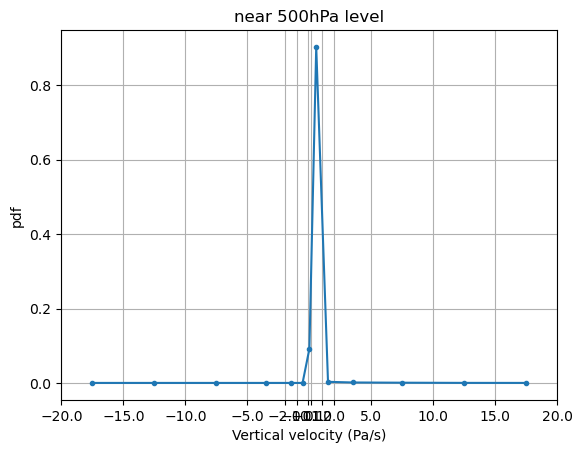

In [16]:
# data = w.sel(lev=500, method="nearest").values.flatten()
data = w.max(axis=1)
print(data.shape)
data = data.values.flatten()
hist, bins = np.histogram(data, bins=[-20,-15,-10,-5,-2,-1,-0.1,0.1,1,2,5,10,15,20])
bin_mids = (bins[1:]+bins[:-1])/2
hist = hist/len(data)

fig, ax = plt.subplots(1,1)
ax.plot(bin_mids,hist,'.-')
ax.set(xticks=bins,xlabel="Vertical velocity (Pa/s)",ylabel="pdf",
      title="near 500hPa level")
ax.grid(True)
plt.show()

In [17]:
ds.OMEGA.mean().values

array(-1.4549777e-05, dtype=float32)

# Animation for OLR, IWP, LWP, PR, TS

We want to see if DP-SCREAM also shows the same tendencies for popcorn convection

In [6]:
run = 'h_halfsed_all'
run

'h_halfsed_all'

In [7]:
# ds = xr.open_dataset("/home/disk/eos1/bloss/Runs/PIRE/DP-SCREAM/Tests/RCE_SMALL_al/scream_dp_RCE_SMALL_al.eam.h1.2000-01-01-00000.nc")
ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run, run))
olr = ds.FLUT
prl = ds.PRECL*3600*1000
iwp = ds.TGCLDIWP*1000
lwp = ds.TGCLDLWP*1000
swn = ds.FSNT
swu = ds.FSUTOA
ts = ds.TS
lat = ds.lat
lon = ds.lon
x = ds.crm_grid_x
y = ds.crm_grid_y
iwp

<xarray.DataArray 'TGCLDIWP' (time: 481, ncol: 1296)>
array([[5.4228451e-07, 5.4228451e-07, 5.4228451e-07, ..., 5.4228451e-07,
        5.4228451e-07, 5.4228451e-07],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.3988003e+01, 1.8660847e+01, 1.1395047e+01, ..., 9.5952587e+00,
        2.7200121e+01, 2.2119864e+01],
       [6.9515343e+00, 1.0941696e+01, 1.8019136e+01, ..., 1.4586294e+00,
        9.4039071e-01, 2.5029101e+00],
       [1.3657988e+01, 1.5937280e+01, 1.8374071e+01, ..., 1.1011716e+01,
        6.5304966e+00, 9.2685032e+00]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-03-02 00:00:00
Dimensions without coordinates: ncol

## calculate albedo

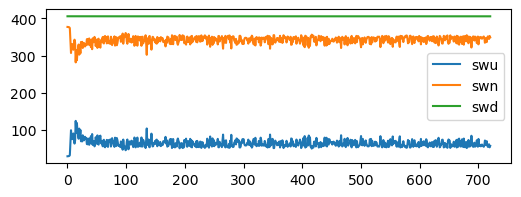

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,2))
ax.plot(range(len(swu.time)), swu.weighted(ds.area).mean(dim=["ncol"]), label="swu")
ax.plot(range(len(swu.time)), swn.weighted(ds.area).mean(dim=["ncol"]), label="swn")
ax.plot(range(len(swu.time)), (swn+swu).weighted(ds.area).mean(dim=["ncol"]), label="swd")
plt.legend()
plt.show()

In [22]:
alb = swu / (swu+swn)

## joint histogram

In [5]:
from matplotlib import cm, ticker, colors
from scipy.interpolate import griddata

def dennisplot(stat, olr, alb, var=None, xbins=None, ybins=None, 
               levels=None, model="model", region="TWP", var_name="var_name",units="units", 
               cmap=cm.ocean_r, ax=None, save=False, colorbar_on=True, fs=20):
    ''' Returns axis with contourf of olr and albedo.
    
    Parameters:
        - stat (str)   : - 'difference' returns contourf of the difference between the first minus the second in the tuple
                         - 'density' returns density plot of olr-alb joint histogram (pdf), or
                         - statistic for scipy.stats.binned_statistic_2d
        - olr (array)  : 1-D array of OLR values (from 85-310 W/m2), 
        - alb (array)  : 1-D array of Albedo values (from 0-1),
        - var (array)  : 1-D array (var is optional if stat=density or difference)
        - colorbar_on (bool)
                       : returns a tuple of ax, mappable_countour if False
                       
    Returns: 
        - ax (plt.axis): axis with plot 
        - cs (mappable): returned value from plt.contourf, if colorbar_on = False
        
    Note: Values for mean sw downward flux at toa from 
              http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture11%20--%20Insolation.html. 
    '''
    if xbins is None:
        xbins = np.linspace(70,320,26)
    if ybins is None:
        ybins = np.linspace(0,0.8,33)
    if levels is None:
        if stat=="difference":
            levels = np.arange(-0.9,1,0.2)
        else:
            levels = np.arange(-3,-1.2,0.1)
    if stat=="difference":
        print("difference")
        olr0, olr1 = olr
        alb0, alb1 = alb
        olr0 = olr0[~np.isnan(alb0)]
        alb0 = alb0[~np.isnan(alb0)]
        alb0 = alb0[~np.isnan(olr0)]
        olr0 = olr0[~np.isnan(olr0)]
        olr1 = olr1[~np.isnan(alb1)]
        alb1 = alb1[~np.isnan(alb1)]
        alb1 = alb1[~np.isnan(olr1)]
        olr1 = olr1[~np.isnan(olr1)]
        hist0, xedges, yedges = np.histogram2d(olr0,alb0,bins=(xbins,ybins))
        nan_len = np.sum(~np.isnan(alb0))
        hist0 = hist0/nan_len
        print(nan_len)
        hist1, xedges, yedges = np.histogram2d(olr1,alb1,bins=(xbins,ybins))
        nan_len = np.sum(~np.isnan(alb1))
        hist1 = hist1/nan_len
        print(nan_len)
        binned_stat = hist0-hist1
    else:
        if (olr.shape!=alb.shape) and (var is not None):
            raise Exception("shapes don't match: olr %s, alb %s, %s %s."%(olr.shape, alb.shape, var_name, var.shape))
        elif var is not None:
            if (olr.shape!=var.shape) or (alb.shape!=var.shape):
                raise Exception("shapes don't match: olr %s, alb %s, %s %s."%(olr.shape, alb.shape, var_name, var.shape))
        elif (olr.shape!=alb.shape):
            raise Exception("shapes of alb and olr don't match: %s != %s"%(alb.shape, olr.shape))
        olr = olr[~np.isnan(alb)]
        if stat!='density':
            var = var[~np.isnan(alb)]
        alb = alb[~np.isnan(alb)]
        alb = alb[~np.isnan(olr)]
        if stat!='density':
            var = var[~np.isnan(olr)]
        olr = olr[~np.isnan(olr)]
        if stat!='density':
            alb = alb[~np.isnan(var)]
            olr = olr[~np.isnan(var)]
            var = var[~np.isnan(var)]
        if stat=='density':
            # check for nans
            binned_stat, xedges, yedges = np.histogram2d(olr,alb,bins=(xbins,ybins))
            nan_len = xr.DataArray(alb).count().values
            binned_stat = binned_stat/(nan_len)
            print(nan_len)
        else: 
            var = var[~np.isnan(olr)]
            binned_stat, xedges, yedges, nbins = stats.binned_statistic_2d(olr, alb, var, 
                                                                          bins=(xbins,ybins), statistic=stat)
    xbins2, ybins2 = (xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2
    if ax is None:
        ax = plt.gca()
    if stat=="difference":
        csn = ax.contourf(xbins2, ybins2, binned_stat.T*100, levels, cmap=cmap, extend='both')
    else:
        csn = ax.contourf(xbins2, ybins2, np.log10(binned_stat.T), levels, cmap=cmap, extend='both')
        co = ax.contour(csn, colors='k', linestyles='solid', linewidths=1)
    if region=="NAU":
        ax.plot([80,317],[0.57,0.],label="Neutral CRE", color='black') # calculated in line_neutral_cre.ipynb
    elif region=="TWP":
        ax.plot([80,309],[0.55,0.],label="Neutral CRE", color='black') # calculated in line_neutral_cre.ipynb
    else:
        ax.plot([80,320],[0.75,0.2],label="Neutral CRE", color='black') # calculated in line_neutral_cre.ipynb
    ax.grid()
    ax.set_xticks([100,150,200,250,300])
    ax.set_ylim([0.05,0.8])
    ax.set_xlim([80,310])
    ax.set_xlabel('OLR(W m$^{-2}$)', size=fs)
    ax.set_ylabel('Albedo', size=fs)
    if var is not None:
        ax.set_title('{m} {v} {n}'.format(m=model, v=var_name, n=region), size=fs)
    else:
        ax.set_title('{m} {n}\n'.format(m=model, n=region), size=fs)
    ax.tick_params(axis='both',labelsize=fs)
    if len(olr)>10:
        ax.text(300,0.75,"{l} Profiles".format(l=len(olr)), fontsize=fs, color="0.3", ha="right")

    # plot the colorbar
    if colorbar_on:
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("right", size="5%", pad=0.05)

        cb = plt.colorbar(csn, ax=ax, shrink=0.8)
        cb.ax.tick_params(labelsize=fs-4)
        if stat=="density":
            cb.set_label('log10(pdf)', fontsize=fs)
        elif stat=="difference":
            cb.set_label('pdf % difference', fontsize=fs)
            cb.set_ticks((levels[1:]+levels[:-1])/2)
        else:
            cb.set_label('log10(%s) (%s)'%(stat, units), fontsize=fs)
    if save:
        plt.savefig('../plots/olr_alb/native_%s_%s_%s_%s.png'%(var_name.lower().replace(" ","_"), 
                                                               stat, model, region[:3]), bbox_inches="tight")
        print('    saved as ../plots/olr_alb/native_%s_%s_%s_%s.png'%(var_name.lower().replace(" ","_"), 
                                                                   stat, model, region[:3]))
    if colorbar_on:
        ret = ax
    else:
        ret = ax, csn
    return ret

In [6]:
native_grid=False
runs=["i_lsascent_a"]
#["f_default","g_halfdep", "g_2xdep","h_halfdep_all","h_2xdep_all"]

regridding...

...done (1441, 100, 100) (1441, 100, 100)
...coarsened...
...plotting...
23056


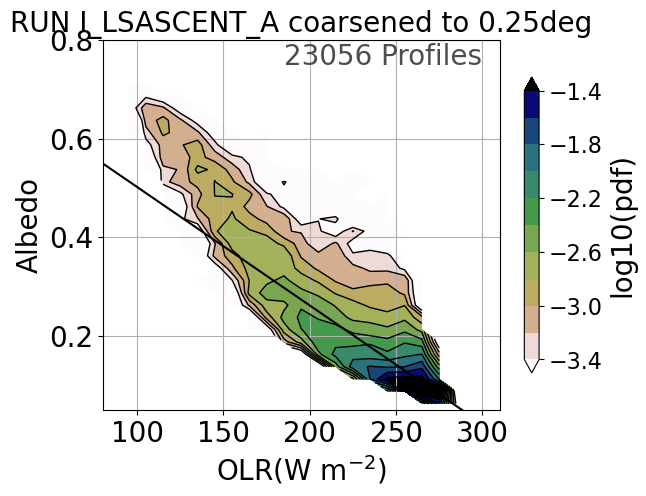

In [7]:
for i in range(len(runs)):
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_"+runs[i]+\
                         "/run/scream_dp_RCE_SMALL_3km_"+runs[i]+\
                         ".eam.h1.2000-01-01-00000.nc")
    olr = ds.FLUT
    swu = ds.FSUTOA
    alb = swu / (swu+ds.FSNT)
    x = ds.crm_grid_x
    y = ds.crm_grid_y
    # plot on native or coarsened to 0.25 deg
    if not(native_grid):
        xi = np.linspace(0, 107170, 100)  # to regrid to ~2km
        yi = np.linspace(0, 107170, 100)  # to regrid to ~2km
        olr_regridded = np.full((len(olr.time), len(xi), len(yi)), np.nan)
        alb_regridded = np.full(olr_regridded.shape, np.nan)
        print("regridding...")
        for t in range(len(olr.time)):
            olr_regridded[t,:,:] = griddata((x[t], y[t]), olr[t], (xi[None,:], yi[:,None]), method='linear')
            alb_regridded[t,:,:] = griddata((x[t], y[t]), alb[t], (xi[None,:], yi[:,None]), method='linear')
        print("\n...done", olr_regridded.shape, alb_regridded.shape)

        olr_regridded = xr.DataArray(olr_regridded, dims=["time","xi","yi"], 
                                     coords={"time":olr.time,"xi":xi,"yi":yi})
        alb_regridded = xr.DataArray(alb_regridded, dims=["time","xi","yi"], 
                                     coords={"time":olr.time,"xi":xi,"yi":yi})
        olr_coarsened = olr_regridded.coarsen(dim={"xi":25,"yi":25}).mean(skipna=True)
        alb_coarsened = alb_regridded.coarsen(dim={"xi":25,"yi":25}).mean(skipna=True)
        print("...coarsened...\n...plotting...")

        dennisplot("density",olr_coarsened.values.flatten(), alb_coarsened.values.flatten(),
                   cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2))
        plt.title("RUN {} coarsened to 0.25deg".format(runs[i].upper()), fontsize=20)
        plt.savefig("plots/jhist_0.25deg_{}.png".format(runs[i]), dpi=140)
        plt.show()
    else:
        dennisplot("density",olr.values.flatten(), alb.values.flatten(),
                   cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2))
        plt.title("RUN {} native output".format(runs[i].upper()), fontsize=20)
        plt.savefig("plots/jhist_native_{}.png".format(runs[i]), dpi=140)
        plt.show()

## spatial plots

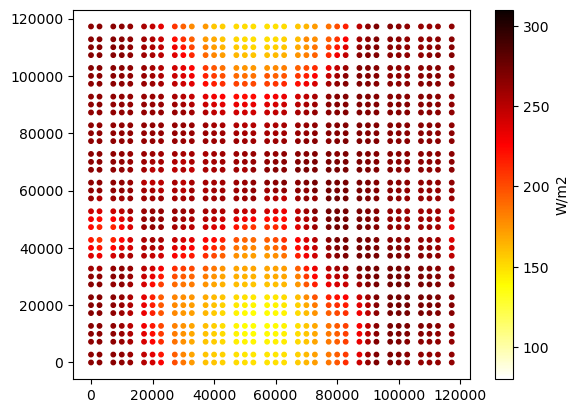

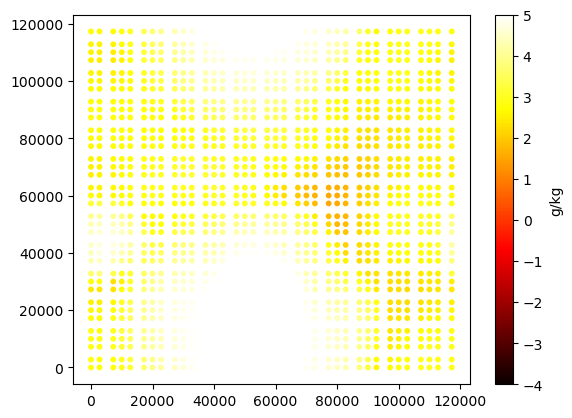

In [36]:
cmap="hot"
cmapr="hot_r"

# scatter plot of native grid OLR
t = 45
im = plt.scatter(x.values[t,:], y.values[t,:], c=olr[t,:].values, 
                 s=10, vmin=80, vmax=310, cmap=cmapr)
plt.colorbar(im, label="W/m2")
plt.show()
im = plt.scatter(x.values[t,:], y.values[t,:], c=np.log10(iwp[t,:].values)+3, 
                 s=10, vmin=-4, vmax=5, cmap=cmap)
plt.colorbar(im, label="g/kg")
plt.show()

In [38]:
# tripcolor plot of native grid OLR
# t=50
for t in range(len(olr.time)-2):
    print(t, end=" ")
    fig, ax = plt.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0)
    # plot
    im_olr = ax[0].tripcolor(x.values[t,:], y.values[t,:], olr[t,:].values, 
                       vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
    fig.colorbar(im_olr, ax=ax[0], orientation="horizontal", label="W/m2", shrink=0.8)
    im_iwp = ax[1].tripcolor(x.values[t,:], y.values[t,:], iwp[t,:].values, 
                       norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4), shading="gouraud",
                            cmap=cmap)
    fig.colorbar(im_iwp, ax=ax[1], label="g/m$^2$", orientation="horizontal", shrink=0.8)
    im_pr = ax[2].tripcolor(x.values[t,:], y.values[t,:], (lwp[t,:].values), 
                       shading="gouraud", cmap=cmap, norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
    fig.colorbar(im_pr, ax=ax[2], label="g/m$^2$", orientation="horizontal", shrink=0.8)
    im_pr = ax[3].tripcolor(x.values[t,:], y.values[t,:], (prl[t,:].values), 
                       shading="gouraud", cmap=cmap, norm=mcolors.LogNorm(vmin=0.1, vmax=40))
    fig.colorbar(im_pr, ax=ax[3], label="mm/hr", orientation="horizontal", shrink=0.8)
    # figure settings
    for i in range(4):
        ax[i].set_aspect("equal")
        ax[i].set_xlim([0,107171])
        ax[i].set_ylim([0,107171])
    fig.suptitle("{} (TS_rad = {:03g} K)".format(str(olr[t].time.values), (ts[t,5].values)))
    ax[0].set_title("OLR")
    ax[1].set_title("IWP")
    ax[2].set_title("LWP")
    ax[3].set_title("PR")
    ax[3].set_facecolor(cm.get_cmap(cmap,10)(0))
    ax[2].set_facecolor(cm.get_cmap(cmap,10)(0))
    plt.savefig("plots/movie/{}/tripcolor_olr-iwp-pr_{:03d}".format(run, t), bbox_inches="tight", pad_inches=0.5)
    plt.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

50 

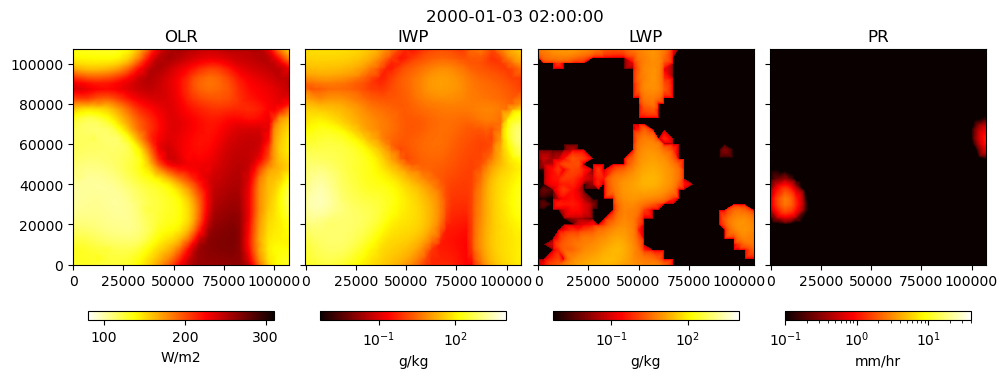

In [21]:
# griddata
print(t, end=" ")
# regrid
xi = np.linspace(0, 107170, 1000)  # to regrid to ~2km
yi = np.linspace(0, 107170, 1000)  # to regrid to ~2km
olr_regridded = griddata((x[t], y[t]), olr[t], (xi[None,:], yi[:,None]), method='linear')
iwp_regridded = griddata((x[t], y[t]), iwp[t], (xi[None,:], yi[:,None]), method='linear')
lwp_regridded = griddata((x[t], y[t]), lwp[t], (xi[None,:], yi[:,None]), method='linear')
prl_regridded = griddata((x[t], y[t]), prl[t], (xi[None,:], yi[:,None]), method='linear')
X,Y = np.meshgrid(xi,yi)
# plot
fig, ax = plt.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)
for i in range(4):
    ax[i].set_aspect("equal")
im_olr = ax[0].pcolormesh(X,Y, olr_regridded, 
                   vmin=80, vmax=310, cmap=cmapr)
fig.colorbar(im_olr, ax=ax[0], orientation="horizontal", label="W/m2", shrink=0.8)
im_iwp = ax[1].pcolormesh(X,Y, iwp_regridded, cmap=cmap,
                   norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
fig.colorbar(im_iwp, ax=ax[1], label="g/kg", orientation="horizontal", shrink=0.8)
im_lwp = ax[2].pcolormesh(X,Y, lwp_regridded, cmap=cmap,
                   norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
fig.colorbar(im_lwp, ax=ax[2], label="g/kg", orientation="horizontal", shrink=0.8)
im_pr = ax[3].pcolormesh(X,Y, prl_regridded, cmap=cmap,
                   norm=mcolors.LogNorm(vmin=0.1, vmax=40))
fig.colorbar(im_pr, ax=ax[3], label="mm/hr", orientation="horizontal", shrink=0.8)
fig.suptitle(str(olr[t].time.values))
ax[0].set_title("OLR")
ax[1].set_title("IWP")
ax[2].set_title("LWP")
ax[3].set_title("PR")
ax[3].set_facecolor(cm.get_cmap(cmap,10)(0))
ax[2].set_facecolor(cm.get_cmap(cmap,10)(0))
plt.savefig("plots/movie/pcolormesh_griddata_olr-iwp-pr_{:03d}".format(t), bbox_inches="tight", pad_inches=0.5)
plt.show()

In [22]:
len(x[t]), len(y[t]), olr[t].shape

(1296, 1296, (1296,))